Optimizando parámetros de la fuente...
Parámetros óptimos encontrados:
  - Sigma (ancho del pulso): 0.00172
  - Delay (centro del pulso): 0.0103 s
  - Frecuencia pico del espectro de velocidad: 92.73 Hz
  - Caída en los extremos de la banda: -9.18 dB


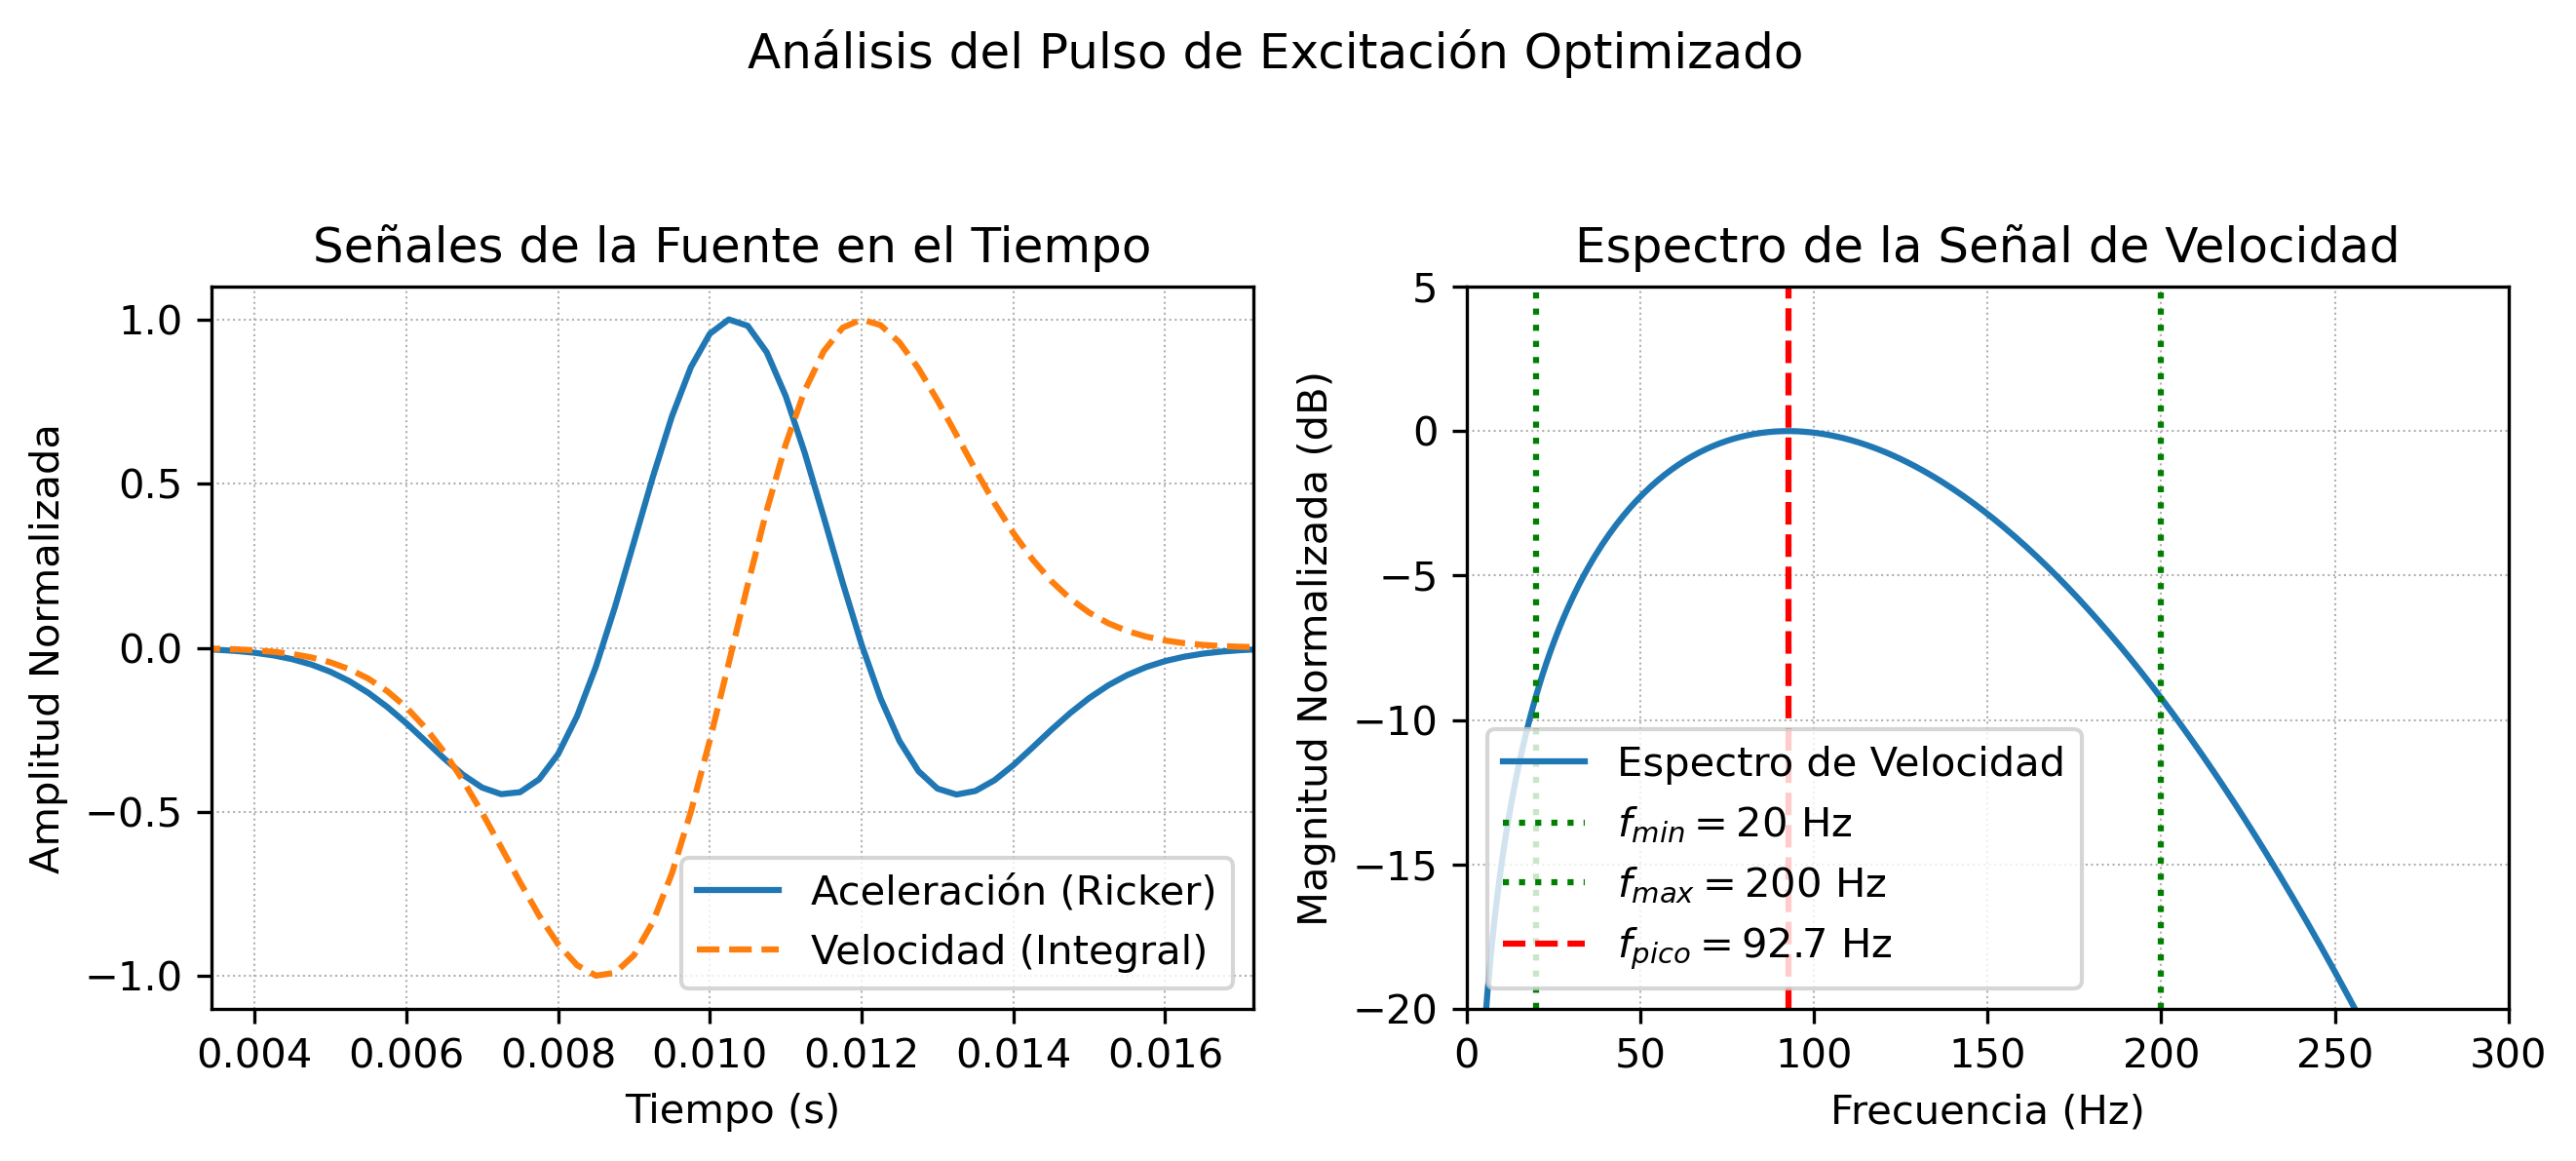

In [2]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
from scipy.optimize import brentq
from scipy.integrate import cumulative_trapezoid
import scipy.fft as fft

# --- FUNCIONES AUXILIARES ---

def optimizar_fuente_para_velocidad(f_min, f_max, amplitude=1.0, delay_factor=6.0):
    # ... (Esta función ya era correcta y no necesita cambios) ...
    if f_min <= 0 or f_max <= f_min:
        raise ValueError("Las frecuencias deben ser positivas y f_max > f_min.")
    def get_db_drop_velocidad(f, sigma):
        if sigma < 1e-12: return -np.inf
        fp = 1.0 / (2 * np.pi * sigma)
        R = f / fp
        if R < 1e-9: return -np.inf
        magnitude_ratio = R * np.exp(0.5 - (R**2 / 2.0))
        if magnitude_ratio < 1e-100: return -2000.0
        return 20 * np.log10(magnitude_ratio)
    def error_function(sigma):
        drop_at_fmin = get_db_drop_velocidad(f_min, sigma)
        drop_at_fmax = get_db_drop_velocidad(f_max, sigma)
        return drop_at_fmin - drop_at_fmax
    try:
        fp_alto = f_max * 5; sigma_min = 1.0 / (2 * np.pi * fp_alto)
        fp_bajo = f_min / 5; sigma_max = 1.0 / (2 * np.pi * fp_bajo)
        sigma_optimo = brentq(error_function, sigma_min, sigma_max)
    except ValueError:
        raise RuntimeError("No se pudo encontrar un sigma que equilibre las atenuaciones.")
    A = amplitude; sigma = sigma_optimo; delay = delay_factor * sigma
    fp_resultante_velocidad = 1.0 / (2 * np.pi * sigma)
    db_drop_resultante = get_db_drop_velocidad(f_max, sigma)
    return A, sigma, delay, fp_resultante_velocidad, db_drop_resultante

# --- FUNCIÓN CORREGIDA ---
def source_acceleration(t_eval, source_delay, sigma, amplitude):
    """
    Genera una ondícula de Ricker (aceleración) usando la definición estándar
    que es consistente con la fórmula del espectro en el optimizador.
    """
    t_shifted = t_eval - source_delay
    # La forma correcta, consistente con exp(-t^2 / (2*sigma^2))
    term_squared = (t_shifted / sigma)**2
    return amplitude * (1.0 - term_squared) * np.exp(-term_squared / 2.0)


# --- BLOQUE PRINCIPAL DE EJECUCIÓN (sin cambios) ---

if __name__ == "__main__":
    fmin = 20
    fmax = 200

    print("Optimizando parámetros de la fuente...")
    A, sigma, delay, fp_resultante_velocidad, db_drop_resultante = optimizar_fuente_para_velocidad(fmin, fmax)
    print("Parámetros óptimos encontrados:")
    print(f"  - Sigma (ancho del pulso): {sigma:.5f}")
    print(f"  - Delay (centro del pulso): {delay:.4f} s")
    print(f"  - Frecuencia pico del espectro de velocidad: {fp_resultante_velocidad:.2f} Hz")
    print(f"  - Caída en los extremos de la banda: {db_drop_resultante:.2f} dB")

    # --- Generación y ploteo (sin cambios) ---
    T_final = (1 / fmin) * 20 
    fs = fmax * 20
    dt = 1 / fs
    t = np.arange(0, T_final, dt)
    accel_t = source_acceleration(t, delay, sigma, A)
    velo_t = cumulative_trapezoid(accel_t, dx=dt, initial=0)
    V_f = fft.rfft(velo_t)
    freqs = fft.rfftfreq(len(velo_t), dt)
    mag_db = 20 * np.log10(np.abs(V_f))
    mag_db_normalized = mag_db - np.max(mag_db)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
    
    ax1.set_title('Señales de la Fuente en el Tiempo')
    ax1.plot(t, accel_t / np.max(np.abs(accel_t)), label='Aceleración (Ricker)', lw=1.5)
    ax1.plot(t, velo_t / np.max(np.abs(velo_t)), label='Velocidad (Integral)', linestyle='--', lw=1.5)
    ax1.set_xlabel('Tiempo (s)'); ax1.set_ylabel('Amplitud Normalizada')
    ax1.legend(); ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax1.set_ylim(-1.1, 1.1)
    plot_time_window_start = max(0, delay - 4 * sigma)
    plot_time_window_end = delay + 4 * sigma
    ax1.set_xlim(plot_time_window_start, plot_time_window_end)

    ax2.set_title('Espectro de la Señal de Velocidad')
    ax2.plot(freqs, mag_db_normalized, label='Espectro de Velocidad', lw=1.5)
    ax2.axvline(fmin, color='g', linestyle=':', lw=1.5, label=f'$f_{{min}} = {fmin}$ Hz')
    ax2.axvline(fmax, color='g', linestyle=':', lw=1.5, label=f'$f_{{max}} = {fmax}$ Hz')
    ax2.axvline(fp_resultante_velocidad, color='r', linestyle='--', lw=1.5, label=f'$f_{{pico}} = {fp_resultante_velocidad:.1f}$ Hz')
    ax2.set_xlabel('Frecuencia (Hz)'); ax2.set_ylabel('Magnitud Normalizada (dB)')
    ax2.set_xlim(0, fmax * 1.5); ax2.legend()
    ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax2.set_ylim(-20, 5)

    plt.suptitle('Análisis del Pulso de Excitación Optimizado', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()